# African Wildlife Object Classification

The purpose if this project is to build a model from a pretrained model to identify wild life in africa.
In essence, This is an object classification for the classification of 4 classes of animal in africa, buffalos, elephants, rhinoes and zebras.

We explain with a lot of details the different section of our pipeline and display metrics, results and the testing evaluation of model.

Group Members:
### Braulio J Cespedes: 101501661
### Luis Alfredo Nogales: 101512133
### Alimul Hasan Jami: 101474810
### Isha Jayswal: 101510506
### Pranali Karande: 101471932
### Mohammad Abuhanood: 101437484

In [ ]:
# This section is done to upload kaggle configuration files
from google.colab import files
files.upload()

In [2]:
# We install the library that we are going to use for this project
# We need to clarify that a lot of the library use for displaying
# and plotting data is already pre install in google colab
!pip install kaggle
!pip install opencv-python

In [3]:
#We move our kaggle configuration file to a different directory and
#give them permission so the os can access the file
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# Download African Wildlife Dataset from Kaggel

This dataset is contains around 376 images for each animal, the list of animals are elephants, buffalo, zebras and rhinos.

In [21]:
!kaggle datasets download -d biancaferreira/african-wildlife

Dataset URL: https://www.kaggle.com/datasets/biancaferreira/african-wildlife
License(s): unknown
100% 447M/448M [00:23<00:00, 18.4MB/s]
100% 448M/448M [00:23<00:00, 19.8MB/s]


In [25]:
# Unzip file and move the data into images directory
!unzip -qq african-wildlife.zip -d ./images

# Exploring the dataset images

In this section, we take a look at a sample of images from our dataset.

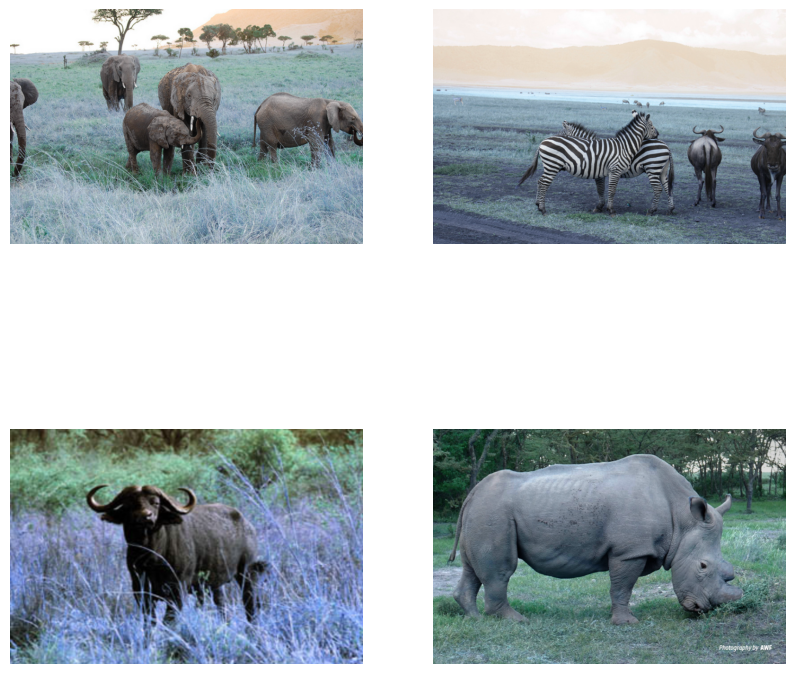

In [26]:
import os
import matplotlib.pyplot as plt
import cv2

# From our images directory
images_path = "./images"
# We get a sample from each of the directories that would serve as our classes
elephant_image = os.path.join(images_path, 'elephant', os.listdir(os.path.join(images_path, 'elephant'))[1])
zebra_image = os.path.join(images_path, 'zebra', os.listdir(os.path.join(images_path, 'zebra'))[1])
buffalo_image = os.path.join(images_path, 'buffalo', os.listdir(os.path.join(images_path, 'buffalo'))[1])
rhino_image = os.path.join(images_path, 'rhino', os.listdir(os.path.join(images_path, 'rhino'))[1])

sample_images = [elephant_image, zebra_image, buffalo_image, rhino_image]

plt.figure(figsize=(10,10))

for i in range(len(sample_images)):
  img = cv2.imread(sample_images[i])
  img = cv2.resize(img, [600,400])
  ax = plt.subplot(2, 2, i + 1)
  plt.imshow(img)
  plt.axis("off")

plt.show()


# Preparing the data and Applying some data preprocessing

In [38]:
# We need to preparer the data to adjust it for our Model.
# We decide to split the data into 70% for training, 20% for validation and 10% for testing

#Preparing the directories for the data split
base_dir = "dataset_split"
#Training data directories
os.makedirs(os.path.join(base_dir, 'train/buffalo'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'train/elephant'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'train/rhino'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'train/zebra'), exist_ok=True)
#Validation
os.makedirs(os.path.join(base_dir, 'validation/buffalo'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'validation/elephant'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'validation/rhino'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'validation/zebra'), exist_ok=True)
#Testing
os.makedirs(os.path.join(base_dir, 'test/buffalo'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'test/elephant'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'test/rhino'), exist_ok=True)
os.makedirs(os.path.join(base_dir, 'test/zebra'), exist_ok=True)


In [39]:
from PIL import Image
import shutil
from sklearn.model_selection import train_test_split

#Using Pillow (PIL) to only copy the images
def is_valid_image_pillow(filename):
    try:
        with Image.open(filename) as img:
            img.verify()
            return True
    except (IOError, SyntaxError):
        return False

#We create a method to split the dataset into their directories
def split_data(SOURCE, TRAINING, VALIDATION, TESTING, split_size_train, split_size_val):
  files = []
  for filename in os.listdir(SOURCE):
    if is_valid_image_pillow(f'{SOURCE}/{filename}'):
      file = os.path.join(SOURCE, filename)
      if os.path.isfile(file):
        files.append(file)

  #After getting the images, we split them into the percentages previously mentioned
  train_files, temp_files = train_test_split(files, test_size=(1 - split_size_train))
  val_files, test_files = train_test_split(temp_files, test_size=(1 - split_size_val / (1 - split_size_train)))

# Copying the files into their directories
  for file in train_files:
    shutil.copy(file, TRAINING)

  for file in val_files:
    shutil.copy(file, VALIDATION)

  for file in test_files:
    shutil.copy(file, TESTING)

base_dir = './dataset_split'
classes = ['buffalo', 'elephant', 'rhino', 'zebra']

for cls in classes:
  split_data(
      SOURCE=f'images/{cls}',
      TRAINING=f'{base_dir}/train/{cls}',
      VALIDATION=f'{base_dir}/validation/{cls}',
      TESTING=f'{base_dir}/test/{cls}',
      split_size_train=0.7,
      split_size_val=0.2
  )

# Applying normalization and Loading the splited dataset
In this part we apply normalization while generating the datasets for each group.

In [43]:
import tensorflow as tf

base_dir = './dataset_split'

def load_dataset(data_dir, img_size, batch_size):
    dataset = tf.keras.preprocessing.image_dataset_from_directory(
        data_dir,
        labels='inferred',
        label_mode='int',
        image_size=(img_size, img_size),
        batch_size=batch_size,
        shuffle=True
    )
    return dataset

img_size = 224
batch_size = 32

train_dataset = load_dataset('dataset_split/train', img_size, batch_size)
val_dataset = load_dataset('dataset_split/validation', img_size, batch_size)
test_dataset = load_dataset('dataset_split/test', img_size, batch_size)

Found 1276 files belonging to 4 classes.
Found 646 files belonging to 4 classes.
Found 393 files belonging to 4 classes.


In [41]:
# Access class names and their indices to confirm that the images are in the correct dataset
# This way we have an idea of what are our classes and their IDs
class_names = train_dataset.class_names
class_indices = {class_name: idx for idx, class_name in enumerate(class_names)}

print("Class Names:", class_names)
print("Class Indices:", class_indices)

Class Names: ['buffalo', 'elephant', 'rhino', 'zebra']
Class Indices: {'buffalo': 0, 'elephant': 1, 'rhino': 2, 'zebra': 3}


# Data augmentation
We don't have a lot of pictures for our training operation, so we use data augmentation to reduce the posibility the overfitting and increase the amount of samples.


In [18]:
from tensorflow import keras
from keras import layers
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
        layers.RandomZoom(0.2)
    ]
)

# Get the pretrained model, VGG16.
VGG16 is a deep convolutional neural used for image classification.
Checking the model and making sure there are not trainable parameters.

In [89]:
# We get the model from keras and use the weights from imagenet
# It's possible to use another models weight, but we are not going to explore that posibility in this project.
conv_base = keras.applications.vgg16.VGG16(
    weights = "imagenet",
    include_top= False
)
# We set the parameter trainable as False
# We prefer to leave the weights of the model as it is, and only train the last layers that we are going to add.
conv_base.trainable = False
conv_base.summary()

80134624/80134624 [==============================] - 1s 0us/step
Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                              

# Training Model
In this point, we are going to use the model VGG16 with the weight of imagenet

In [46]:
from tensorflow import keras
from keras import layers
from tensorflow.keras.regularizers import l2

inputs = keras.Input(shape=(img_size, img_size, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
# GlobalAveragePooling2D help us reduce the dimension and It also help us reduce the amount of parameters.
# Reducing the amount of parameters is crucial at reducing potentia for overfitting and save some resources.
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(512, activation = 'relu', kernel_regularizer=l2(0.001))(x)
x = layers.Dropout(0.5)(x) #It would seen too harsh to dropout half of the neuron,
# but in other experiment for classification problems this approach has proveed to yield good results
outputs = layers.Dense(4, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

In [47]:
from tensorflow.keras.optimizers import Adam
# Compile the model
model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
    )

In [48]:
#Final overview at the model before training
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 tf.__operators__.getitem_2  (None, 224, 224, 3)       0         
  (SlicingOpLambda)                                              
                                                                 
 tf.nn.bias_add_2 (TFOpLamb  (None, 224, 224, 3)       0         
 da)                                                             
                                                                 
 vgg16 (Functional)          (None, None, None, 512)   14714688  
                                                                 
 global_average_pooling2d_2  (None, 512)               0   

In [51]:
# Defining some callbacks Checkpoint and early stopping
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath ="./vgg16_african_wildlife_classifier5.h5",
        save_best_only=True,
        monitor="val_loss"
    ),
    keras.callbacks.EarlyStopping(monitor="loss", patience=3)
]
# Checkpoint to save the best model during training
# Early stopping to get the best possible model if the loss experince no changes or minor changes during 3 epoch
# Early stopping also helps us avoid overfitting by finalizing the training under the conditions of minor loss change.

In [52]:
# Training the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    callbacks = callbacks,
    epochs=50
)
# We started with 10 epoch, we notice that the model was learning and It didn't appear to be overffiting
# So we increase the number of epoch to 50, along with the early stoping assure us to get the possible model during training.


Epoch 1/50
33/33 [==============================] - 15s 379ms/step - loss: 3.5743 - accuracy: 0.3964 - val_loss: 1.3645 - val_accuracy: 0.7300


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/50
33/33 [==============================] - 13s 354ms/step - loss: 2.1773 - accuracy: 0.5779 - val_loss: 0.9737 - val_accuracy: 0.8733
Epoch 3/50
33/33 [==============================] - 15s 371ms/step - loss: 1.7562 - accuracy: 0.6644 - val_loss: 0.8456 - val_accuracy: 0.8967
Epoch 4/50
33/33 [==============================] - 13s 331ms/step - loss: 1.5176 - accuracy: 0.7348 - val_loss: 0.8043 - val_accuracy: 0.9133
Epoch 5/50
33/33 [==============================] - 13s 331ms/step - loss: 1.3361 - accuracy: 0.7548 - val_loss: 0.7679 - val_accuracy: 0.9433
Epoch 6/50
33/33 [==============================] - 13s 342ms/step - loss: 1.1361 - accuracy: 0.7890 - val_loss: 0.7665 - val_accuracy: 0.9567
Epoch 7/50
33/33 [==============================] - 13s 346ms/step - loss: 1.1807 - accuracy: 0.7880 - val_loss: 0.7425 - val_accuracy: 0.9500
Epoch 8/50
33/33 [==============================] - 14s 365ms/step - loss: 1.0506 - accuracy: 0.8346 - val_loss: 0.7441 - val_accuracy: 0.9633

During Training we manage to get an Accuracy of 87%, but at the same time our accuracy for our validation was much much higher. This is due to the harsher regulation that we applied previously, Dropout of 50% and l2 kernerl regularization. At this point the callback for early stopping decided to stop the training. In the evaluation of with the testing data we'll see if our model posees an acceptable accuracy, or if the data shows sight of overfitting.

# Evaluating of the training.
In this section, We evaluate the results of the training of the model.
As well as we do try to test the model with an image that It has probably look into.

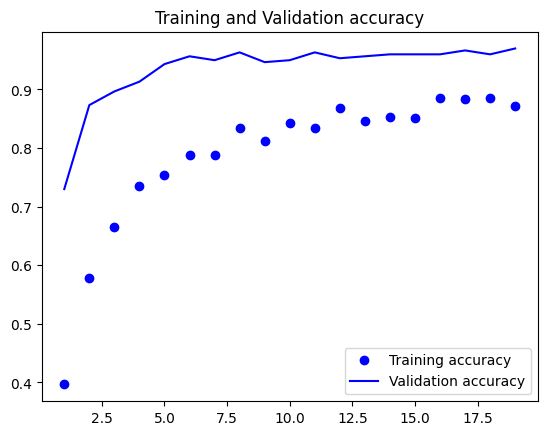

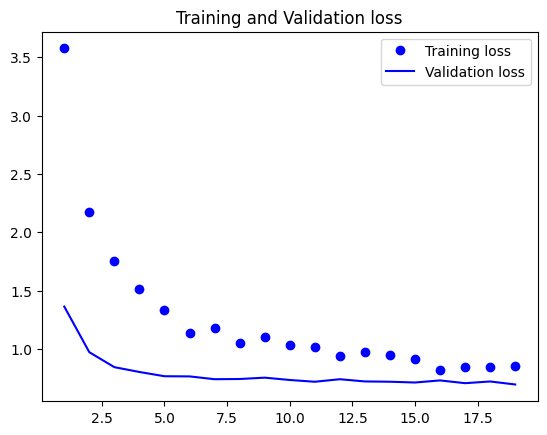

In [54]:
import matplotlib.pyplot as plt


# We look into the epoch and how the training was performing with the data.
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and Validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and Validation loss")
plt.legend()
plt.show()

Our graph also reflect this behavior, The training accuracy and loss are lower than the validation but the way of the graph tell us that our model was indeed learning instead of memorizing the dataset.

# Testing and evaluation of the model
Now we are going to evaluate our model based on the testing of the test_dataset.
This is the final evaluation for our model and what is going to tell us if It was correctly trained.

Evaluating the model over the test dataset gave us an accuracy of over 95%. In this case It was 96%, but depending of the data it could increase as high as 98%.

In [44]:
from tensorflow import keras
#Let's try to see how the model perform with the test dataset.
test_model = keras.models.load_model("/content/vgg16_african_wildlife_classifier5.h5")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"Test accuracy: {test_acc: .3f}")

13/13 [==============================] - 5s 184ms/step - loss: 0.6527 - accuracy: 0.9618
Test accuracy:  0.962


Accuracy is one part, but to have a better idea, we go futher.
We are going to create the confusion matrix and ROC graph to see how the performance in other metrics.

In [45]:
import numpy as np

# Get true labels and predicted labels
true_labels = []
predicted_labels = []
predicted_probabilities = []

for images, labels in test_dataset:
    predictions = test_model.predict(images)
    predicted_labels.extend(np.argmax(predictions, axis=1))
    predicted_probabilities.extend(predictions)
    true_labels.extend(labels.numpy())

true_labels = np.array(true_labels)
predicted_labels = np.array(predicted_labels)
predicted_probabilities = np.array(predicted_probabilities)

1/1 [==============================] - 0s 150ms/step


Here we create our Classification report to evaluate the true positive, true negative, false positive and false negative.

Also the ROC Graph, this graph is typically use for binary classification but, we can also use for multi class classification to se the performance of the different classes.

Classification Report:
              precision    recall  f1-score   support

     buffalo       1.00      0.94      0.97       158
    elephant       0.97      0.98      0.97       159
       rhino       0.78      0.95      0.86        38
       zebra       1.00      1.00      1.00        38

    accuracy                           0.96       393
   macro avg       0.94      0.97      0.95       393
weighted avg       0.97      0.96      0.96       393



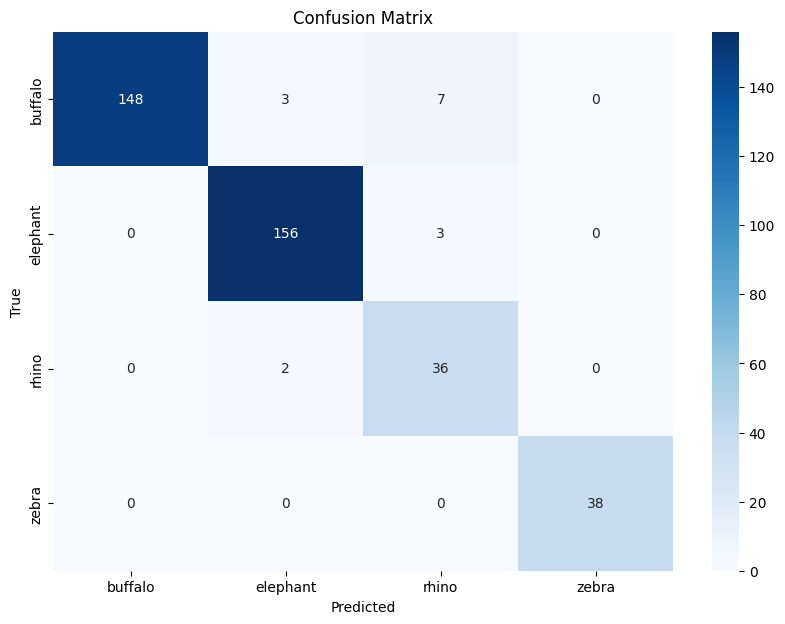

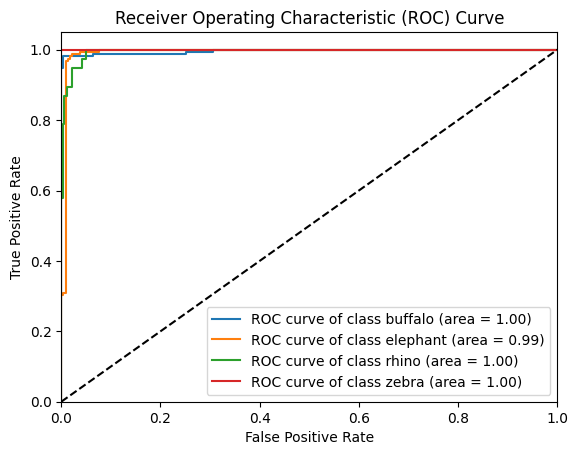

In [46]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import label_binarize

# Class labels
class_labels = ['buffalo', 'elephant', 'rhino', 'zebra']

# Classification Report
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))

# Confusion Matrix
cm = confusion_matrix(true_labels, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# ROC Curve and AUC
true_labels_binarized = label_binarize(true_labels, classes=[0, 1, 2, 3])
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = len(class_labels)

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], predicted_probabilities[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure()
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {class_labels[i]} (area = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Conclusion

We managed to train a VGG16 model to classify pictures between 4 different classes. From our orginal dataset we split the data, prepare it and use a pretrained model with its weight, where we then create a layer over the one we train it with our dataset.
Thanks to this, the training was relative resources friendly and the complexity from our layers was also relative moderate. It wasn't necessary for us to built an architecture from the scrath saving us a lot of time while provinding with reasonable accuracy for the task.

## Leason learned
There were a lot of lesson learned during the creating of this project. Most important one where:
-Splitting the dataset: We needed to split the dataset without using the default tools from sklearn or the one provide from Tensorflow or Keras. Manually we needed to move the images and then load the dataset.

-Getting the classes from the dataset: Minor detail, but necessary. Understanding that some of the tools can infer the classes based on the directory was a welcome finding.

-Data augmentation: We tested different configurations with this part of the pipeline. We identify that our dataset didn't have enough images so this was a necesity to avoid overfitting.

-Getting the pretrained model and building the layers: We first started with a flatten and dense layer without regularitation, but not only this prove to be too resource hungry, It took a lot of time to train. Ultimately, we found GlobalAveragePooling2D function to reduce the dimension and the parameters to train.

-The importance of evaluation: Our first iteration was overfitting, without the evaluation of the training, We wouldn't find out about this and do the necessary stepts to reduce it.